In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools


import sklearn as skn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA as pca

import warnings
warnings.filterwarnings('ignore')

In [48]:
rs = 42

df = pd.read_csv('NY-House-Dataset.csv')
df.columns

Index(['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [49]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [50]:
sel_cols = ['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE' , 'LATITUDE' , 'LONGITUDE']
df = df[sel_cols]
df.head()


,TYPE,BEDS,BATH,PROPERTYSQFT,PRICE,LATITUDE,LONGITUDE
0,Condo for sale,2,2.000000,1400.0,315000,40.761255,-73.974483
1,Condo for sale,7,10.000000,17545.0,195000000,40.766393,-73.980991
2,House for sale,4,2.000000,2015.0,260000,40.541805,-74.196109
3,Condo for sale,3,1.000000,445.0,69000,40.761398,-73.974613
4,Townhouse for sale,7,2.373861,14175.0,55000000,40.767224,-73.969856


In [51]:
df.TYPE.unique()

array(['Condo for sale', 'House for sale', 'Townhouse for sale',
       'Co-op for sale', 'Multi-family home for sale', 'For sale',
       'Contingent', 'Land for sale', 'Foreclosure', 'Pending',
       'Coming Soon', 'Mobile house for sale', 'Condop for sale'],
      dtype=object)

In [52]:
df['TYPE'] = df['TYPE'].str.replace(' for sale' , '')
df.loc[df['TYPE'] == 'Condop' , 'TYPE'] = 'Condo'
df.TYPE.value_counts()

TYPE
Co-op                1450
House                1012
Condo                 896
Multi-family home     727
Townhouse             299
Pending               243
Contingent             88
Land                   49
For sale               20
Foreclosure            14
Coming Soon             2
Mobile house            1
Name: count, dtype: int64

In [53]:
keep_types = ['Co-op' , 'House' , 'Condo' , 'Multi-family home']
df.loc[~(df.TYPE.isin(keep_types)) , 'TYPE'] = 'Other'

df.describe()

,BEDS,BATH,PROPERTYSQFT,PRICE,LATITUDE,LONGITUDE
count,4801.000000,4801.000000,4801.000000,4.801000e+03,4801.000000,4801.000000
mean,3.356801,2.373861,2184.207862,2.356940e+06,40.714227,-73.941601
std,2.602315,1.946962,2377.140894,3.135525e+07,0.087676,0.101082
min,1.000000,0.000000,230.000000,2.494000e+03,40.499546,-74.253033
25%,2.000000,1.000000,1200.000000,4.990000e+05,40.639375,-73.987143
50%,3.000000,2.000000,2184.207862,8.250000e+05,40.726749,-73.949189
75%,4.000000,3.000000,2184.207862,1.495000e+06,40.771923,-73.870638
max,50.000000,50.000000,65535.000000,2.147484e+09,40.912729,-73.702450


In [54]:
lower_iqr = np.nanpercentile(df.PRICE , 10)
upper_iqr = np.nanpercentile(df.PRICE , 90)

iqr = upper_iqr - lower_iqr

lower_bound = lower_iqr - (1.5 * iqr)
upper_bound = upper_iqr + (1.5 * iqr)


df = df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_iqr)]

In [55]:
len(df.TYPE.unique())

5

In [56]:
house_types = sorted(df.TYPE.unique())

fig = make_subplots(rows = 3 , cols=2 , subplot_titles=house_types)

row_idx = 1
col_idx = 1

for i in range(len(house_types)):
    if row_idx > 3:
        row_idx = 1
        col_idx += 1
    fig.add_trace(go.Histogram(x=df[df.TYPE == house_types[i]]['PRICE'] , name=house_types[i]) , row=row_idx , col=col_idx)
    row_idx += 1

fig.update_layout(title_text='Price Distribution by House Type' , height=800 , width=1000)

In [57]:
fig = px.scatter(data_frame=df, x = 'PROPERTYSQFT', y = 'PRICE' , facet_col= 'TYPE' , trendline= 'ols' )
fig.show()

In [58]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()


In [59]:
house_types = df["TYPE"].unique()

res = []

# Compare all pairs of house types
for a, b in itertools.combinations(house_types, 2):
    prices_a = df[df["TYPE"] == a]["PRICE"]
    prices_b = df[df["TYPE"] == b]["PRICE"]
    t_stat, p_val = ttest_ind(prices_a, prices_b, equal_var=False)  # Welch’s t-test
    temp = {
        "comparison": f"{a} vs {b}",
        "t-stat": t_stat,
        "p-value": p_val
    }
    res.append(temp)

res = pd.DataFrame(res)


rejected, pvals_corrected, _, _ = multipletests(res['p-value'], alpha=0.05, method='bonferroni')

res['p_value_corrected'] = pvals_corrected
res['rejected'] = rejected

res

,comparison,t-stat,p-value,p_value_corrected,rejected
0,Condo vs House,0.655672,5.121420e-01,1.000000e+00,False
1,Condo vs Co-op,12.985471,2.009558e-36,2.009558e-35,True
2,Condo vs Other,-1.059309,2.896784e-01,1.000000e+00,False
3,Condo vs Multi-family home,-7.889212,6.020736e-15,6.020736e-14,True
4,House vs Co-op,15.338456,1.847715e-50,1.847715e-49,True
5,House vs Other,-1.753068,7.991883e-02,7.991883e-01,False
6,House vs Multi-family home,-10.060748,4.590764e-23,4.590764e-22,True
7,Co-op vs Other,-12.378599,1.532662e-32,1.532662e-31,True
8,Co-op vs Multi-family home,-24.098947,6.177607e-108,6.177607e-107,True
9,Other vs Multi-family home,-5.843790,6.817599e-09,6.817599e-08,True


In [60]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()

In [61]:
bath_price = df.groupby('BATH')['PRICE'].mean().reset_index()

# Reshape price for clustering
X = bath_price['PRICE'].values.reshape(-1, 1)

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=rs).fit(X)
bath_price['BATH_GROUP'] = kmeans.labels_

# Map back
bath_group_map = dict(zip(bath_price['BATH'], bath_price['BATH_GROUP']))
df['BATH_GROUP'] = df['BATH'].map(bath_group_map)



fig = px.box(data_frame=df, x = 'BATH_GROUP', y = 'PRICE' , color= 'BATH_GROUP' )
fig.show()

In [62]:
bath_groups = sorted(df['BATH_GROUP'].unique())

for group in bath_groups:
    print(f"Group {group}:")
    print(f"Unique bath values: {df[df['BATH_GROUP'] == group]['BATH'].unique().astype(str)}")

Group 0:
Unique bath values: ['2.3738608579684373' '3.0' '4.0' '6.0' '8.0' '5.0' '9.0' '7.0']
Group 1:
Unique bath values: ['10.0' '32.0' '16.0' '24.0' '12.0']
Group 2:
Unique bath values: ['2.0' '1.0' '0.0']


In [63]:
# Get average price per bath type
bed_price = df.groupby('BEDS')['PRICE'].mean().reset_index()

# Reshape price for clustering
X = bed_price['PRICE'].values.reshape(-1, 1)

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=rs).fit(X)
bed_price['BEDS_GROUP'] = kmeans.labels_

# Map back
bed_group_map = dict(zip(bed_price['BEDS'], bed_price['BEDS_GROUP']))
df['BEDS_GROUP'] = df['BEDS'].map(bed_group_map)



fig = px.box(data_frame=df, x = 'BEDS_GROUP', y = 'PRICE' , color= 'BEDS_GROUP' )
fig.show()

In [64]:
bed_groups = sorted(df['BEDS_GROUP'].unique())

for group in bed_groups:
    print(f"Group {group}:")
    print(f"Unique bed values: {df[df['BEDS_GROUP'] == group]['BEDS'].unique().astype(str)}")

Group 0:
Unique bed values: ['5' '6' '12' '10' '11' '8' '7' '9' '15' '14' '16' '20' '13' '19']
Group 1:
Unique bed values: ['36' '24' '18']
Group 2:
Unique bed values: ['2' '4' '3' '1']


In [65]:
df['combined_cols'] = df['BEDS_GROUP'].astype(str) + df['BATH_GROUP'].astype(str) + df['TYPE'].astype(str)
value_counts = df['combined_cols'].value_counts()
df = df[df['combined_cols'].isin(value_counts[value_counts >= 8].index)]
print(df.shape)

(4304, 10)


In [66]:
categorical_cols = ['BEDS_GROUP' , 'BATH_GROUP' , 'TYPE']

X = df.drop(columns = ['PRICE' ])
y = np.log(df['PRICE'])

for col in categorical_cols:
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes

In [67]:
def make_scaler(feature):
    scaler = MinMaxScaler()
    feature = scaler.fit_transform(feature.values.reshape(-1, 1))
    return feature , scaler

In [68]:
X['Area'] = X['PROPERTYSQFT']
X['Area_sqrt'] = np.sqrt(X['Area'])
X['Area_log'] = np.log(X['Area'])
X['Area_2'] = X['Area'] ** 2
X['Area_3'] = X['Area'] ** 3


X['Lat'] = X['LATITUDE']
X['Lat_2'] = X['Lat'] ** 2
X['Lat_3'] = X['Lat'] ** 3


X['Lon'] = X['LONGITUDE']
X['Lon_2'] = X['Lon'] ** 2
X['Lon_3'] = X['Lon'] ** 3




X_train, X_test, y_train, y_test = train_test_split(X , y , test_size = 0.25 , random_state = 42, stratify=X['combined_cols'])


X_train['Area'] , area_scaler = make_scaler(X_train['Area'])
X_train['Area_sqrt'] , area_sqrt_scaler = make_scaler(X_train['Area_sqrt'])
X_train['Area_log'] , area_log_scaler = make_scaler(X_train['Area_log'])
X_train['Area_2'] , area_2_scaler = make_scaler(X_train['Area_2'])
X_train['Area_3'] , area_3_scaler = make_scaler(X_train['Area_3'])

X_test['Area'] = area_scaler.transform(X_test['Area'].values.reshape(-1, 1))
X_test['Area_sqrt'] = area_sqrt_scaler.transform(X_test['Area_sqrt'].values.reshape(-1, 1))
X_test['Area_log'] = area_log_scaler.transform(X_test['Area_log'].values.reshape(-1, 1))
X_test['Area_2'] = area_2_scaler.transform(X_test['Area_2'].values.reshape(-1, 1)) 
X_test['Area_3'] = area_3_scaler.transform(X_test['Area_3'].values.reshape(-1, 1))



X_train['Lat'] , lat_scaler = make_scaler(X_train['Lat'])

X_train['Lat_2'] , lat_2_scaler = make_scaler(X_train['Lat_2'])
X_train['Lat_3'] , lat_3_scaler = make_scaler(X_train['Lat_3'])

X_test['Lat'] = lat_scaler.transform(X_test['Lat'].values.reshape(-1, 1))
X_test['Lat_2'] = lat_2_scaler.transform(X_test['Lat_2'].values.reshape(-1, 1)) 
X_test['Lat_3'] = lat_3_scaler.transform(X_test['Lat_3'].values.reshape(-1, 1))


X_train['Lon'] , lon_scaler = make_scaler(X_train['Lon'])
X_train['Lon_2'] , lon_2_scaler = make_scaler(X_train['Lon_2'])
X_train['Lon_3'] , lon_3_scaler = make_scaler(X_train['Lon_3'])

X_test['Lon'] = lon_scaler.transform(X_test['Lon'].values.reshape(-1, 1))
X_test['Lon_2'] = lon_2_scaler.transform(X_test['Lon_2'].values.reshape(-1, 1)) 
X_test['Lon_3'] = lon_3_scaler.transform(X_test['Lon_3'].values.reshape(-1, 1))





y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)) 
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

drop_cols = ['BEDS' , 'BATH' , 'PROPERTYSQFT' , 'combined_cols']


X_train = X_train.drop(columns = drop_cols)
X_test = X_test.drop(columns = drop_cols)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (3228, 16)
y_train shape: (3228, 1)
X_test shape: (1076, 16)
y_test shape: (1076, 1)


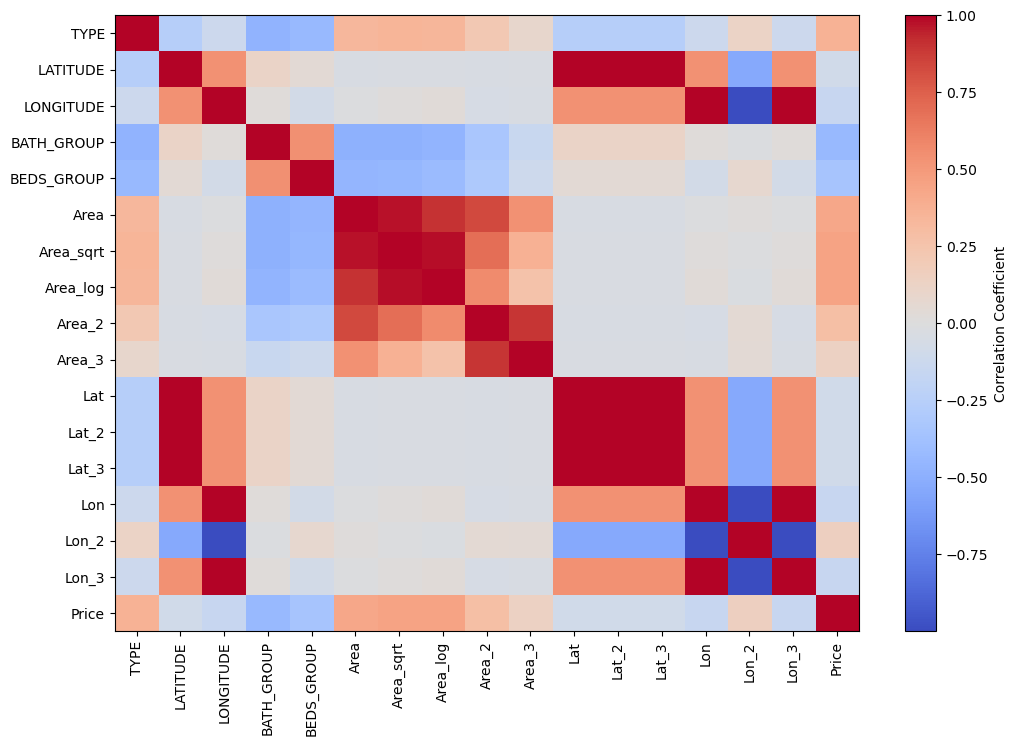

In [69]:
X_train['Price'] = y_train


corr_mat = X_train.corr()
plt.figure(figsize=(12, 8))

plt.imshow(corr_mat, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
plt.yticks(range(len(corr_mat.columns)), corr_mat.columns)

plt.show()


In [70]:
def train_and_evaluate_model(model, scaler , X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    

    y_train_pred = model.predict(X_train)
    y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

    
    y_test_pred = model.predict(X_test)
    y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
    ret = {
        'model_name' : type(model).__name__ , 
        'y_train_pred' : y_train_pred,
        'y_test_pred' : y_test_pred,
        'test_rmse' : rmse,
        'test_mape' : mape 
        
    }
    
    
    return ret

In [71]:
X_train = X_train.drop('Price' , axis = 1)

rf = RandomForestRegressor(
    n_estimators=100,
    criterion= 'friedman_mse',
    random_state=rs
)

rf.fit(X_train, y_train)



feat_imp = pd.DataFrame([X_train.columns.transpose() , rf.feature_importances_.transpose()] , index = ['feature' , 'importance']).transpose().sort_values(by = 'importance' , ascending = False)

feat_imp



,feature,importance
14,Lon_2,0.181791
0,TYPE,0.168021
3,BATH_GROUP,0.122555
11,Lat_2,0.050316
10,Lat,0.049294
1,LATITUDE,0.048037
13,Lon,0.046094
12,Lat_3,0.044763
7,Area_log,0.044557
15,Lon_3,0.043016


In [72]:
model_features = feat_imp[feat_imp['importance'] >= 0.05]['feature'].values.tolist()

In [73]:
models = [
         LinearRegression(),
         DecisionTreeRegressor(criterion= 'squared_error' ,  random_state=rs),
         RandomForestRegressor(criterion= 'friedman_mse' , n_estimators=100 , random_state=rs),
         KNeighborsRegressor(n_neighbors=5 , weights='distance' , algorithm='auto')
         ]



results = [train_and_evaluate_model(model, y_scaler, X_train[model_features], y_train, X_test[model_features], y_test) for model in models]


fig = make_subplots(rows=2, cols=2  , subplot_titles=[f"{result['model_name']}" for result in results])

row_idx = 1
col_idx = 1

y_train = np.exp(y_scaler.inverse_transform(y_train.reshape(-1, 1)))


for _ , result in enumerate(results):
    
    if row_idx > 2:
        row_idx = 1
        col_idx += 1
    
    y_train_pred = np.exp(result['y_train_pred'])
    res = y_train_pred - y_train

    fig.add_trace(
        go.Scatter(
            x=y_train_pred.ravel(),
            y=res.ravel(),
            mode='markers' ,
            name = result['model_name'] ,
            hovertext=y_train.ravel() ,
            hoverinfo='text'),
        row=row_idx, col=col_idx
        )
    
    row_idx += 1


fig.update_layout(
    height=1200,  
    width=1300,
    xaxis_title="Predicted Price",
    yaxis_title="Residuals",  
    title_text="Residual Plots for each model"
    
)


fig.show()

In [74]:
y_test = np.exp(y_scaler.inverse_transform(y_test.reshape(-1, 1)))

fig = make_subplots(rows=2, cols=2  , subplot_titles=[f"{result['model_name']} RMSE = {result['test_rmse']:.2f} MAPE = {result['test_mape']:.2f}" for result in results])

row_idx = 1
col_idx = 1

for _ , result in enumerate(results):
    
    if row_idx > 2:
        row_idx = 1
        col_idx += 1
    
    y_test_pred = np.exp(result['y_test_pred'])

    fig.add_trace(go.Scatter(x=y_test.ravel(), y=y_test_pred.ravel(), mode='markers' , name = result['model_name']),
              row=row_idx, col=col_idx)
    
    row_idx += 1


fig.update_layout(
    xaxis_title="Actual Price",
    yaxis_title="Predicted Price",
    height=1200,  
    width=1300,  
    title_text="Predicted vs acutal prices on test set"
)


fig.show()



In [75]:
[result['model_name'] for result in results]

['LinearRegression',
 'DecisionTreeRegressor',
 'RandomForestRegressor',
 'KNeighborsRegressor']